In [1]:
import random
import networkx as nx
from IPython.core.display import SVG
import pyomo.environ as pyo
from pysat.solvers import Solver
from pysat.formula import CNF 
import py_svg_combinatorics as psc
from ipywidgets import widgets, HBox
from collections import Counter
from pprint import pprint
from random import randint
import numpy as np
from IPython.display import IFrame
import IPython
from copy import copy
import os
from pathlib import Path

def print_solution(m):
    for v in m.component_data_objects(pyo.Var):
        if v.value and v.value > 0:
            print(str(v), v.value)

nbname = ''
try:
    nbname = __vsc_ipynb_file__
except:
    if 'COCALC_JUPYTER_FILENAME' in os.environ:
        nbname = os.environ['COCALC_JUPYTER_FILENAME']    
title_ = Path(nbname).stem.replace('-', '_').title()    
IFrame(f'https://discopal.ispras.ru/index.php?title=Hardprob/{title_}&useskin=cleanmonobook', width=1280, height=300)


In [2]:
def visme(G, m=None):
    def norm_size(sz):
        return int(sz*100)

    pos = nx.get_node_attributes(G, "pos")
    if not pos:
        pos = nx.spring_layout(G)
        nx.set_node_attributes(G, pos, "pos")
    cut_edges = None 
    v_colors = ['blue'] * len(G.nodes())
    if m:
        k = int(pyo.value(m.число_разбиений))
        last_color = 0
        p_colors_ = psc.get_hex_palette_for_n(k)
        d_colors_ = {}
        for v in G.nodes():
            for p in m.P:
                if pyo.value(m.vp[v, p]) > 0:
                    if p not in d_colors_:
                        d_colors_[p] = last_color
                        last_color += 1
                    v_colors[v] = p_colors_[d_colors_[p]]

    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        edge_color="green",
        node_color=v_colors,
        node_size=300,
        style=':',
        width=0.6,
        font_size=6
    )


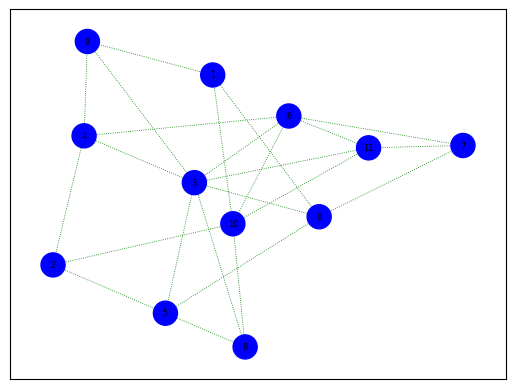

In [3]:
G = nx.fast_gnp_random_graph(12, 0.4)
#G = nx.random_lobster(8, 0.5, 0.5)
visme(G)

In [4]:
def get_model(G):
    m = pyo.ConcreteModel()

    m.E = list(G.edges())
    m.V = list(G.nodes())
    m.m = len(m.E)
    m.n = len(m.V)
    m.P = list(range(m.n))

    # Номер разбиения
    m.vp = pyo.Var(m.V, m.P, domain=pyo.Binary)

    @m.Constraint(m.V)
    def каждая_вершина_в_ровно_одном_разбиении(m, v):
        return sum(m.vp[v, ...]) == 1

    # Существует ли раздел p?
    m.p = pyo.Var(m.P, domain=pyo.Binary)
    m.число_разбиений = pyo.Objective(expr = sum(m.p[...]), sense=pyo.minimize)

    @m.Constraint(m.P)
    def если_разбиение_есть_там_должны_быть_вершины(m, p):
        return sum(m.vp[..., p]) >= m.p[p]

    @m.Constraint(m.V, m.P)
    def если_есть_вершины_в_разбиении_то_оно_должно_быть(m, v, p):
        return m.vp[v, p] <= m.p[p]


    # соединяется ли ребро «uv» с партицией «p»
    m.uvp = pyo.Var(m.E, m.P, domain=pyo.Binary)

    @m.Constraint(m.E, m.P)
    def задаем_uvp_up(m, u, v, p):
        return m.uvp[(u, v), p] <= m.vp[u, p] + m.vp[v, p]

    @m.Constraint(m.E, m.P)
    def задаем_uvp_down_u(m, u, v, p):
        return m.uvp[(u, v), p] >= m.vp[u, p]

    @m.Constraint(m.E, m.P)
    def задаем_uvp_down_v(m, u, v, p):
        return m.uvp[(u, v), p] >= m.vp[v, p]

    @m.Constraint(m.V, m.P)
    def разбиение_должно_быть_если_мы_им_пользуемся(m, v, p):
        return m.vp[v, p] <= m.p[p]

    @m.Constraint(m.P)
    def разбиение_не_должно_быть_если_мы_им_не_пользуемся(m, p):
        return sum(m.vp[..., p]) >= m.p[p]

    @m.Constraint(m.E)
    def каждое_ребро_дожно_быть_на_разрезе_только_когда_вершины_в_двух_разбиениях(m, u, v):
        return sum(m.uvp[(u,v), ...]) == 2

    return m

m = get_model(G)
#m.E, m.V

In [5]:
solver = pyo.SolverFactory('cbc')
solver.solve(m).write()
#print_solution(m)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 3.0
  Upper bound: 3.0
  Number of objectives: 1
  Number of constraints: 1056
  Number of variables: 444
  Number of binary variables: 444
  Number of integer variables: 444
  Number of nonzeros: 12
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 14.27
  Wallclock time: 16.1
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bou

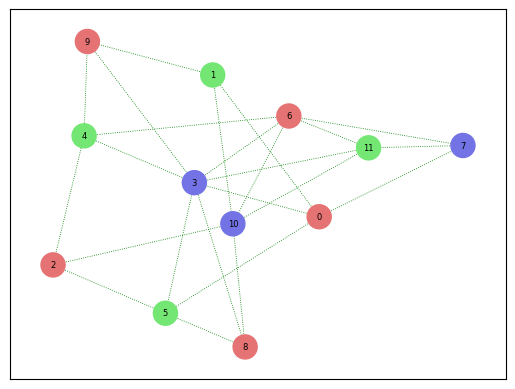

In [6]:
visme(G, m)
